In [647]:
import copy
import bokeh
from bokeh.plotting import show

import numpy as np
import pandas as pd
import math
import os
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import cProfile
import matplotlib.transforms as transforms

import flowkit as fk
import glob as glob

bokeh.io.output_notebook()
%matplotlib inline

_ = plt.ioff()

Loading BokehJS ...

In [648]:
list = np.sort(glob.glob('/Users/aryellewright/Documents/Documents - Aryelle’s MacBook Air/Kumar-Biomaterials-Lab/CellUptake_Plots/Cell Uptake_Aryelle Experiment_02.09.2024/DIPLibrary_NP5NP7.5/*.fcs'))
fcs_path = list[31]
sample = fk.Sample(fcs_path)
sample

Sample(v3.1, D3 DIP G2 NP7.5_003.fcs, 51 channels, 7857 events)

In [649]:
df_events = sample.as_dataframe(source='raw')

f = sample.plot_scatter('FSC-A', 'SSC-A', source='raw')
show(f)

In [650]:
SSC_idx = sample.get_channel_index('SSC-A')
FSC_idx = sample.get_channel_index('FSC-A')
events_SSC= sample.get_channel_events(SSC_idx,source = 'raw')
events_FSC= sample.get_channel_events(FSC_idx,source = 'raw')

g_strat = fk.GatingStrategy()

dim_SSC = fk.Dimension('SSC-A')
dim_FSC = fk.Dimension('FSC-A')

In [651]:
vertices = [
    (176300,344200),
    (283700,392600),
    (379100,548700),
    (556600,2330000),
    (212100,2330000),
    (99840,1119000),
    (80950,527200),
    (98840,398000),
    (134600,344200)
]

poly_gate = fk.gates.PolygonGate(
    'Cells', 
    dimensions=[dim_FSC, dim_SSC],
    vertices=vertices
)

In [652]:
g_strat.add_gate(poly_gate, gate_path=('root',))
res = g_strat.gate_sample(sample)

res.report

,sample,gate_path,gate_name,gate_type,quadrant_parent,parent,count,absolute_percent,relative_percent,level
0,D3 DIP G2 NP7.5_003.fcs,"(root,)",Cells,PolygonGate,None,root,4384,55.797378,55.797378,1


In [653]:
sample_gate = g_strat.gate_sample(sample)
sample_cells_gated = sample_gate.get_gate_membership('Cells')

p = sample.plot_scatter(
    'FSC-A', 'SSC-A', source='raw', subsample=False, color_density = True, highlight_indices=sample_cells_gated)
show(p)

In [654]:
gs_results = g_strat.gate_sample(sample, verbose=True)

cell_gate_membership = gs_results.get_gate_membership('Cells')
cell_gate_membership.sum()

D3 DIP G2 NP7.5_003.fcs: processing gate Cells


4384

In [655]:
def gated_cells (fcs_df, cell_gate_membership_array):
    """This function allows takes in a binary array for cell membership to a gate, along
    with the original dataframe from all the gates cells, and outputs a datafram that only
    include the values relavent to the cells containted within that gate"""

    #intializes column title array as well as the array to store filtered values
    titles = fcs_df.columns.values
    array_for_df = []

    #loops through titles filtering for cells that are contained within the gate
    for i in titles:
        array = df_events[i]
        new_array = []
        for i in range(len(array)):
            if cell_gate_membership_array[i]:
                new_array.append(array[i])

        array_for_df.append(new_array)

    #intializing dictionary to create data frame from
    d = {}

    #matching data with titles in dictionary for dataframe creation
    for i in range(len(titles)):
        d[titles[i]]= array_for_df[i]

    #creating dataframe
    df = pd.DataFrame(d)
    
    return df

In [656]:
cells_df = gated_cells(df_events, cell_gate_membership)
cells_df

,Time,FSC-W,FSC-H,FSC-A,SSC-W,SSC-H,SSC-A,B1-H,B1-A,B2-H,...,R4-H,R4-A,R5-H,R5-A,R6-H,R6-A,R7-H,R7-A,R8-H,R8-A
,,,,,,,,,,,...,,,,,,,,,,
0,0.0000,5.931281e+05,99695.0,98553.171875,7.138776e+05,349733.0,4.161109e+05,66.500000,0.674438,76.700005,...,86.0,-235.110626,356.0,113.494377,337.0,-103.818748,108.0,-178.893127,278.0,-71.825623
1,0.0961,7.034913e+05,138116.0,161939.000000,7.784248e+05,321665.0,4.173200e+05,103.200005,44.696815,98.500000,...,451.0,337.587494,656.0,417.958740,404.0,-220.561874,228.0,56.005623,408.0,-55.652500
2,0.1011,1.402997e+06,87277.0,204082.234375,1.113023e+06,527508.0,9.785476e+05,68.400002,30.322439,79.300003,...,278.0,66.246246,388.0,389.779388,233.0,-11.158750,186.0,-55.158123,577.0,207.637497
3,0.1012,1.078579e+06,149105.0,268035.906250,1.291409e+06,731856.0,1.575209e+06,81.800003,61.080879,75.400002,...,2575.0,1244.765625,2530.0,1008.313110,1594.0,511.466248,967.0,120.909996,476.0,222.115631
4,0.2327,8.504022e+05,107811.0,152804.531250,9.838365e+05,609138.0,9.988203e+05,75.300003,-21.861313,133.600006,...,1632.0,1072.581909,1835.0,741.633118,1118.0,334.762512,741.0,90.188126,534.0,53.533749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4379,249.1310,6.965590e+05,120844.0,140291.625000,8.378937e+05,447930.0,6.255296e+05,103.700005,34.280502,76.900002,...,16389.0,18407.558594,12084.0,14907.595703,8211.0,9634.167969,6779.0,7655.114258,3159.0,3972.444336
4380,249.4305,8.342714e+05,246376.0,342574.062500,1.297812e+06,502844.0,1.087662e+06,83.500000,8.999313,88.200005,...,787.0,1572.959961,1308.0,1682.287476,792.0,1068.061890,562.0,629.974976,568.0,369.933746
4381,249.4317,6.767134e+05,238932.0,269480.812500,7.900227e+05,813360.0,1.070955e+06,60.299999,31.153564,107.599998,...,328.0,382.222504,413.0,17.938749,412.0,-56.358749,267.0,-244.574371,614.0,-387.731262


In [657]:
sample = fk.Sample(cells_df, sample_id='Cells Gate')
f = sample.plot_scatter('SSC-A', 'SSC-H', source='raw')
show(f)

In [658]:
dim_SSC_A = fk.Dimension('SSC-A')
dim_SSC_H = fk.Dimension('SSC-H')


In [659]:
center = (1500000, 700000)
cov = [[9.74944434e+11, 4.92652573e+11], [4.92652573e+11, 2.82662600e+11]]
dist = 1000000

ellipse_gate = fk.gates.EllipsoidGate(
    'Singlet', 
    dimensions=[dim_SSC_A, dim_SSC_H], 
    coordinates=center,
    covariance_matrix=cov,
    distance_square=dist
)
g_strat.add_gate(ellipse_gate, gate_path=('root','Cells'))
res = g_strat.gate_sample(sample)
res.report

,sample,gate_path,gate_name,gate_type,quadrant_parent,parent,count,absolute_percent,relative_percent,level
0,Cells Gate,"(root,)",Cells,PolygonGate,None,root,4384,100.0,100.0,1
1,Cells Gate,"(root, Cells)",Singlet,EllipsoidGate,None,Cells,4384,100.0,100.0,2


In [660]:
sample_gate = g_strat.gate_sample(sample)
sample_cells_gated = sample_gate.get_gate_membership('Singlet')

In [661]:
p = sample.plot_scatter(
    'SSC-A', 'SSC-H', source='raw', subsample=False, color_density = True, highlight_indices=sample_cells_gated)
show(p)

In [662]:
quad_div1 = fk.QuadrantDivider(
    'Cellular Uptake',
    'R3-A',
    compensation_ref='uncompensated', 
    transformation_ref=None, 
    values=[2500]
)

quad_divs = [quad_div1]

# the 2 dividers above will be used to divide the space into 4 quadrants
quad_1 = fk.gates.Quadrant(
    quadrant_id='Cy5 positive',
    divider_refs=['Cellular Uptake'],
    divider_ranges=[(3000, None)]
)
quad_3 = fk.gates.Quadrant(
    quadrant_id='Cy5 negative',
    divider_refs=['Cellular Uptake'],
    divider_ranges=[(None, 3000)]
)

quadrants = [quad_1, quad_3]

# We can now construct our QuadrantGate
quad_gate1 = fk.gates.QuadrantGate(
    'Viability Gate', 
    dividers=quad_divs, 
    quadrants=quadrants
)

In [663]:
g_strat.add_gate(quad_gate1, gate_path=('root','Cells','Singlet',))
res = g_strat.gate_sample(sample)

In [664]:
res.report

,sample,gate_path,gate_name,gate_type,quadrant_parent,parent,count,absolute_percent,relative_percent,level
0,Cells Gate,"(root,)",Cells,PolygonGate,None,root,4384,100.000000,100.000000,1
1,Cells Gate,"(root, Cells)",Singlet,EllipsoidGate,None,Cells,4384,100.000000,100.000000,2
3,Cells Gate,"(root, Cells, Singlet)",Cy5 negative,QuadrantGate,Viability Gate,Singlet,588,13.412409,13.412409,3
2,Cells Gate,"(root, Cells, Singlet)",Cy5 positive,QuadrantGate,Viability Gate,Singlet,3796,86.587591,86.587591,3


In [665]:
sample_gate = g_strat.gate_sample(sample)
sample_cells_gated = sample_gate.get_gate_membership('Cy5 positive')

In [666]:
p = sample.plot_scatter(
    'R2-A', 'B2-A', source='raw', subsample=False, color_density = True, highlight_indices=sample_cells_gated)
show(p)

In [667]:
quad_div2 = fk.QuadrantDivider(
    'Transfection',
    'B2-A',
    compensation_ref='uncompensated', 
    transformation_ref=None, 
    values=[2500]
)

quad_divs = [quad_div2]

# the 2 dividers above will be used to divide the space into 4 quadrants
quad_2 = fk.gates.Quadrant(
    quadrant_id='GFP Positive Cells',
    divider_refs=['Transfection'],
    divider_ranges=[(10000, None)]
)
quad_4 = fk.gates.Quadrant(
    quadrant_id='GFP Negative Cells',
    divider_refs=['Transfection'],
    divider_ranges=[(None, 10000)]
)

quadrants = [quad_2, quad_4]

# We can now construct our QuadrantGate
quad_gate2 = fk.gates.QuadrantGate(
    'Transfection Gate', 
    dividers=quad_divs, 
    quadrants=quadrants
)

In [668]:
g_strat.add_gate(quad_gate2, gate_path=('root','Cells','Singlet','Viability Gate','Cy5 positive',))
res = g_strat.gate_sample(sample)

In [669]:
res.report

,sample,gate_path,gate_name,gate_type,quadrant_parent,parent,count,absolute_percent,relative_percent,level
0,Cells Gate,"(root,)",Cells,PolygonGate,None,root,4384,100.000000,100.000000,1
1,Cells Gate,"(root, Cells)",Singlet,EllipsoidGate,None,Cells,4384,100.000000,100.000000,2
3,Cells Gate,"(root, Cells, Singlet)",Cy5 negative,QuadrantGate,Viability Gate,Singlet,588,13.412409,13.412409,3
2,Cells Gate,"(root, Cells, Singlet)",Cy5 positive,QuadrantGate,Viability Gate,Singlet,3796,86.587591,86.587591,3
5,Cells Gate,"(root, Cells, Singlet, Viability Gate, Cy5 pos...",GFP Negative Cells,QuadrantGate,Transfection Gate,Cy5 positive,3796,86.587591,100.000000,5
4,Cells Gate,"(root, Cells, Singlet, Viability Gate, Cy5 pos...",GFP Positive Cells,QuadrantGate,Transfection Gate,Cy5 positive,0,0.000000,0.000000,5


In [670]:
text = g_strat.get_gate_hierarchy(output='ascii')

In [671]:
print(text)

root
╰── Cells
    ╰── Singlet
        ╰── Viability Gate
            ├── Cy5 positive
            │   ╰── Transfection Gate
            │       ├── GFP Positive Cells
            │       ╰── GFP Negative Cells
            ╰── Cy5 negative


In [672]:
sample_gate = g_strat.gate_sample(sample)
sample_cells_gated = sample_gate.get_gate_membership('GFP Positive Cells')

In [673]:
p = sample.plot_scatter(
    'B2-A', 'SSC-A', source='raw', subsample=False, color_density = True, highlight_indices=sample_cells_gated)
show(p)

In [674]:
def get_file_name(file_path):
    """Given a file path this function finds the file name without the extension"""
    # This will give you the last component of the file path
    file_name_with_extension = os.path.basename(file_path)
    file_name = os.path.splitext(file_name_with_extension)[0]
    return file_name

def modify_file_name(file_path):
    file_name = os.path.basename(file_path)
    # Modify the file_name to remove undesired parts for sorting
    # Adjust the regex according to your file naming conventions
    modified_name = re.sub(r'^[A-Z]\d+\s+', '', file_name)
    modified_name = os.path.splitext(modified_name)[0]  # Optionally remove the file extension
    return modified_name

def geometric_mean(arr):
    """This function calculates the geometric mean of a array, utilizing logarithm rules 
    to minimize the computational size"""
    n = len(arr)
    log_sum = 0
    N = len(arr)
    count = 0

    
    for num in arr:
        if num <= 0:
            count +=1
        else:
            log_sum += math.log(num)

    n = len(arr)-count 
    
    return (math.exp(log_sum / n)),count, N

def gated_cells (fcs_df, cell_gate_membership_array):
    """This function allows takes in a binary array for cell membership to a gate, along
    with the original dataframe from all the gates cells, and outputs a datafram that only
    include the values relavent to the cells containted within that gate"""

    #intializes column title array as well as the array to store filtered values
    titles = fcs_df.columns.values
    array_for_df = []

    #loops through titles filtering for cells that are contained within the gate
    for i in titles:
        array = fcs_df[i]
        new_array = []
        for i in range(len(array)):
            if cell_gate_membership_array[i]:
                new_array.append(array[i])

        array_for_df.append(new_array)

    #intializing dictionary to create data frame from
    d = {}

    #matching data with titles in dictionary for dataframe creation
    for i in range(len(titles)):
        d[titles[i]]= array_for_df[i]

    #creating dataframe
    df = pd.DataFrame(d)
    
    return df

In [675]:
def geo_mean_master_function(path_list):
    
    file_names = []
    geometric_means = []
    number_of_exclusions = []
    num_cells = []
    percent_excluded = []
    
    for i in range(len(path_list)):
        
        path_list_sorted = np.sort(path_list)
        fcs_path = path_list_sorted[i]
        file_name = get_file_name(fcs_path)
        
        sample = fk.Sample(fcs_path)
        df_events = sample.as_dataframe(source='raw')
        
        g_strat = fk.GatingStrategy()
        
        dim_SSC = fk.Dimension('SSC-A')
        dim_FSC = fk.Dimension('FSC-A')

        vertices = [
            (176300,344200),
            (283700,392600),
            (379100,548700),
            (556600,2330000),
            (212100,2330000),
            (99840,1119000),
            (80950,527200),
            (98840,398000),
            (134600,344200)
        ]

        poly_gate = fk.gates.PolygonGate(
            'Cells', 
            dimensions=[dim_FSC, dim_SSC],
            vertices=vertices
        )

        g_strat.add_gate(poly_gate, gate_path=('root',))
        res = g_strat.gate_sample(sample)

        dim_SSC_A = fk.Dimension('SSC-A')
        dim_SSC_H = fk.Dimension('SSC-H')

        center = (1500000, 700000)
        cov = [[9.74944434e+11, 4.92652573e+11], [4.92652573e+11, 2.82662600e+11]]
        dist = 1000000

        ellipse_gate = fk.gates.EllipsoidGate(
            'Singlet', 
            dimensions=[dim_SSC_A, dim_SSC_H], 
            coordinates=center,
            covariance_matrix=cov,
            distance_square=dist
        )

        g_strat.add_gate(ellipse_gate, gate_path=('root','Cells',))
        res = g_strat.gate_sample(sample)
        
        sample_gate = g_strat.gate_sample(sample)
        sample_singlet_gated = sample_gate.get_gate_membership('Singlet')
        
        gated_cel = gated_cells(df_events,sample_singlet_gated)
        
        geometric_mean_calc, number_of_exclusion, num_cell = geometric_mean(gated_cel['R2-A'])
        
        file_names.append(file_name)
        geometric_means.append(np.round(geometric_mean_calc,4))
        number_of_exclusions.append(number_of_exclusion)
        num_cells.append(num_cell)
        percent_excluded.append(np.round(((number_of_exclusion/num_cell)*100),4))
    
    
    dict_df = {'Sample Name' : file_names,'Geometric Mean' : geometric_means, 'Number of Exclusions' : number_of_exclusions, 'Number of Cells' : num_cells
              , 'Percent Excluded' : percent_excluded}
    geo_mean_df = pd.DataFrame(dict_df)
    
    return geo_mean_df

In [676]:
fcs_path = list[31]
sample = fk.Sample(fcs_path)

In [677]:
sample_gate = g_strat.gate_sample(sample)
sample_singlet_gated = sample_gate.get_gate_membership('Singlet')
f = sample.plot_scatter('SSC-A', 'SSC-H', source='raw',subsample=False, color_density = True, highlight_indices=sample_singlet_gated)
show(f)

gated_cel = gated_cells(df_events,sample_singlet_gated)

In [678]:
gated_cell = gated_cells(df_events,sample_singlet_gated)
gated_cell['R2-A']

0         210.462494
1         565.070618
2         239.277496
3        2937.576172
4        1834.766846
            ...     
4379    43396.097656
4380     4668.736328
4381       61.090626
4382     7514.641113
4383     3686.978027
Name: R2-A, Length: 4384, dtype: float64

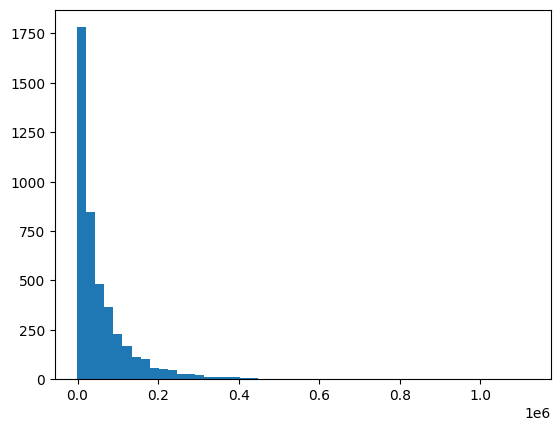

In [679]:
plt.hist(gated_cell['R2-A'],bins=50)
plt.show()

In [680]:
count = 0

for i in gated_cel['R2-A']:
    if i <= 0:
        count += 1

count

37

In [681]:
geometric_mean(gated_cell['R2-A'])

(25740.90302325988, 37, 4384)

In [682]:
f = sample.plot_scatter('SSC-A', 'R2-A', source='raw', subsample=False, color_density = True, highlight_indices=sample_singlet_gated)
show(f)

In [683]:
geo_means = geo_mean_master_function(list)

In [684]:
display(geo_means)

,Sample Name,Geometric Mean,Number of Exclusions,Number of Cells,Percent Excluded
0,A1 DIP S1 NP7.5_001,2371.1354,579,2055,28.1752
1,A2 DIP S1 NP7.5_002,95343.4877,3,1681,0.1785
2,A3 DIP S1 NP7.5_003,81451.6597,0,2074,0.0000
3,A5 DIP B1 NP 5_001,9051.9426,52,5767,0.9017
4,A5 Untreat_2_001,138.7495,3419,8792,38.8876
5,A6 DIP B1 NP 5_002,8645.9307,37,4536,0.8157
6,A6 Untreat_2_002,141.8015,4072,10782,37.7666
7,A7 DIP B1 NP 5_003,8947.1438,56,5193,1.0784
8,A7 Untreat_2_003,137.0135,6225,16047,38.7923
9,B1 DIP B1 NP7.5_001,11050.8746,59,5640,1.0461


In [686]:
geo_means.to_csv('/Users/aryellewright/Documents/Documents - Aryelle’s MacBook Air/Kumar-Biomaterials-Lab/CellUptake_Plots/Cell Uptake_Aryelle Experiment_02.09.2024/DIPLibrary_CellUptake_GeometricMeans.csv', index=False)